# CS 178 Project <br>
### Team 69 - "Adulting" <br>
Members:<br>
Dingyi Chang #89167697<br>
Nicholas King #33099364<br>
Jenny My Lee #11994579<br>

## Import Libraries

In [21]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.tree as tree
from sklearn import preprocessing
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

## Collect Data

In [22]:
#Gather and encode data
tr_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
val_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

header = ["age", "working class", "final weight", "education", "education number", "marital status", "occupation", "relationship", "race", "sex", "capital gain", "capital loss", "hours per week", "native country"]

#Read training data from adult.data and make Xtr and Ytr. Missing values are replaced with NaN.
tr_data = np.array(pd.read_csv(tr_url, sep = ', ', header = None,  na_values='?', engine = 'python'))
val_data = np.array(pd.read_csv(val_url, sep = ', ', header = None, skiprows = 1,  na_values='?', engine = 'python'))

#Encode data to use models in
label_encoder = preprocessing.LabelEncoder()
encoded_tr_data = np.copy(tr_data)
encoded_val_data = np.copy(val_data)
for i in range(tr_data[0].size):
    if isinstance(tr_data[0, i], str):
        label_encoder.fit(tr_data[:, i])
        encoded_tr_data[:, i] = label_encoder.transform(tr_data[:, i])
        label_encoder.fit(val_data[:, i])
        encoded_val_data[:, i] = label_encoder.transform(val_data[:, i])
encoded_tr_data = encoded_tr_data.astype('int')
encoded_val_data = encoded_val_data.astype('int')

#Create X and Y
Xtr_raw = tr_data[:, :14]
Ytr_raw = tr_data[:, 14]
Xval_raw = val_data[:, :14]
Yval_raw = val_data[:, 14]
Xtr = encoded_tr_data[:, :14]
Ytr = encoded_tr_data[:, 14]
Xval = encoded_val_data[:, :14]
Yval = encoded_val_data[:, 14]

## Decision Tree Classifier
Since we are using nominal data, it may be a good idea to implement a decision tree as our machine learning model. The code below will implement a decision tree model at different max depths, $d \in \{1,...,50\}$, and plots the training and validation error.

Text(0, 0.5, 'Error')

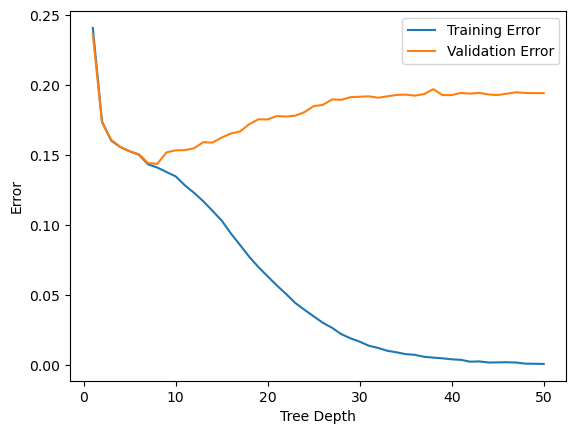

In [23]:
d = list(range(1, 51))   #Depth values for our decision

#Arrays to store training and validation error
tree_te = []
tree_ve = []

#Implement decision trees
for i in d:
    learner = tree.DecisionTreeClassifier(max_depth = i, criterion ='entropy')
    learner.fit(Xtr, Ytr)
    tree_te.append(np.round(zero_one_loss(learner.predict(Xtr), Ytr), 4))
    tree_ve.append(np.round(zero_one_loss(learner.predict(Xval), Yval), 4))

#Plot
plt.plot(d, tree_te)
plt.plot(d, tree_ve)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel("Tree Depth")
plt.ylabel("Error")

What we notice from the graph is that the optimal range for our tree at around $d=7$ and $d=8$, with the values having validation error of under ``0.15``.

## Random Forest Classifier
Our next model will be to use random forests. The code below will implement a random forest with number of trees, $t \in \{1,...,50\} $ and $d = 8$, which then plots the training and validation error.

Text(0, 0.5, 'Error')

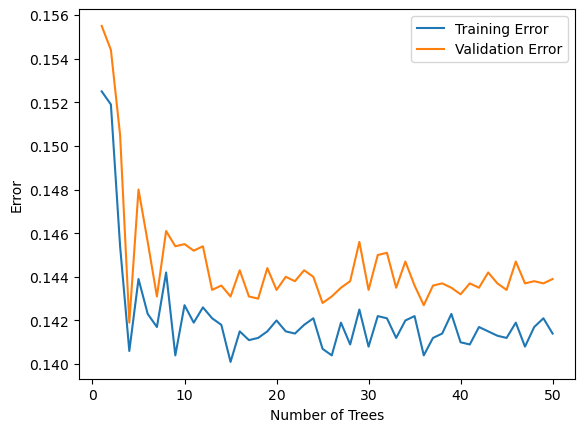

In [24]:
t = list(range(1, 51))   #Number of trees in forest
d = 8                    #Depth values for our decision

#Arrays to store training and validation error
forest_te = []
forest_ve = []

#Implement random forests
for i in t:
    learner = RandomForestClassifier(n_estimators = i, criterion ='entropy', max_depth = d)
    learner.fit(Xtr, Ytr)
    forest_te.append(np.round(zero_one_loss(learner.predict(Xtr), Ytr), 4))
    forest_ve.append(np.round(zero_one_loss(learner.predict(Xval), Yval), 4))

#Plot
plt.plot(t, forest_te)
plt.plot(t, forest_ve)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel("Number of Trees")
plt.ylabel("Error")

We've noticed that our dataset has some missing values in the entries. <br> Below is the code that provides a summary of each feature, the number of missing values of each feature, and the percentage of missing values of each feature.

Feature: age, Number missing 0, Percent Missing: 0.0
Feature: working class, Number missing 1836, Percent Missing: 5.638647461687294
Feature: final weight, Number missing 0, Percent Missing: 0.0
Feature: education, Number missing 0, Percent Missing: 0.0
Feature: education number, Number missing 0, Percent Missing: 0.0
Feature: marital status, Number missing 0, Percent Missing: 0.0
Feature: occupation, Number missing 1843, Percent Missing: 5.660145572924664
Feature: relationship, Number missing 0, Percent Missing: 0.0
Feature: race, Number missing 0, Percent Missing: 0.0
Feature: sex, Number missing 0, Percent Missing: 0.0
Feature: capital gain, Number missing 0, Percent Missing: 0.0
Feature: capital loss, Number missing 0, Percent Missing: 0.0
Feature: hours per week, Number missing 0, Percent Missing: 0.0
Feature: native country, Number missing 583, Percent Missing: 1.7904855501980899


Text(0.5, 1.0, 'Percent Missing')

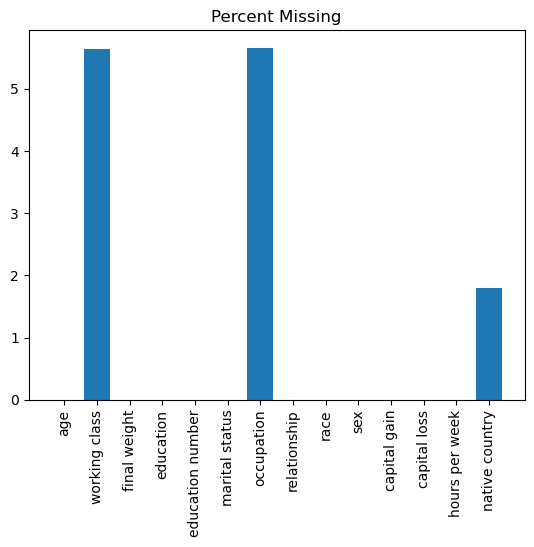

In [25]:
arr_percent_missing = []
for i in range(Xtr_raw[0].size):
 num_missing = pd.isnull(Xtr_raw[:, i]).sum()
 percent_missing = num_missing / Xtr_raw.shape[0] * 100
 arr_percent_missing.append(percent_missing)
 print(f"Feature: {header[i]}, Number missing {num_missing}, Percent Missing: {percent_missing}")
 
plt.bar(header, arr_percent_missing)
plt.xticks(rotation=90)
plt.title("Percent Missing")

For each feature, we want to collect data points that have an unknown value for said feature and predict what feature they will be. <br>

There are several methods which are recommendeded for filling in missing features. <br> The simplest, and most common, is to use the mean or median of the remaining values to fill in a missing value for a numerical feature. For categorical features, the mode is used instead. <br> Although this method is quite simple and fast, it has a few downsides, such as not being accurate, not accounting for the uncertainty of our data imputations, not accounting for the correlations between features, and possibly introducing bias. <br> <br>

Another method is to use k-NN clusters to impute the missing values. We find the k nearest neighbors of the missing entry based on the non-missing features and then fills in the missing value with the average prediction. This method may be more accurate than using the mean/median/mode imputation method described above, depending on the dataset, but it is computationally expensive. <br>
Below is the code that uses k-NN clusters to impute the missing values. The resulting file is saved as FILENAME for convenience.


num_neigbors: 1 , mean: 0.856976097849601 , std: 0.005119448175193004
num_neigbors: 5 , mean: 0.8570681820067757 , std: 0.005362246325130085
num_neigbors: 10 , mean: 0.8575493607041043 , std: 0.0049754738684207106
num_neigbors: 15 , mean: 0.8577234140943075 , std: 0.005011235985977538
num_neigbors: 25 , mean: 0.8579691331994065 , std: 0.005101840702735917
num_neigbors: 50 , mean: 0.8573855322512061 , std: 0.005280675020351234


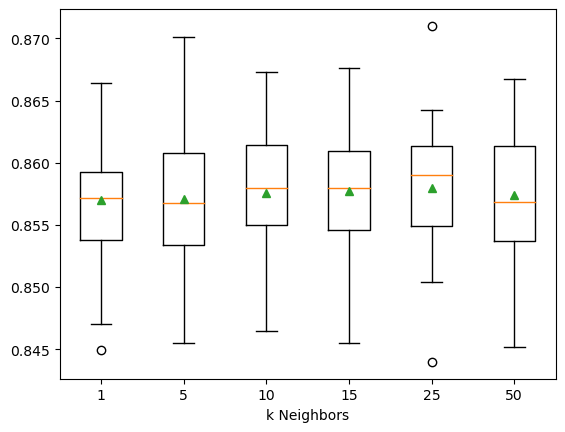

'\nAs seen in the graph below, there is not much variation between the training error, the validation error, and the number of neighbors. \nWe will choose k = 5 because it is the simplest model with the lowest validation error.\n'

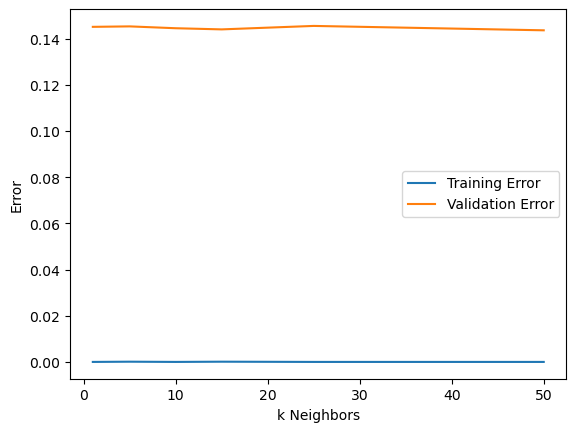

In [35]:
num_neighbors = [1,5,10,15,25,50]
# imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# imputer.fit(Xtr)
# Xtr_transform = imputer.transform(Xtr)

imputer_te = []
imputer_ve = []

results = []

for n in num_neighbors:
    imputer = KNNImputer(n_neighbors = n, weights='uniform', metric='nan_euclidean')
    imputer.fit(Xtr)
    Xtr_trans = imputer.transform(Xtr)
    model = RandomForestClassifier()
    model.fit(Xtr_trans, Ytr)
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, Xtr_trans, Ytr, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
     # store results
    results.append(scores)    
    imputer_te.append(np.round(zero_one_loss(model.predict(Xtr_trans), Ytr), 4))
    imputer_ve.append(np.round(zero_one_loss(model.predict(Xval), Yval), 4))

plt.boxplot(results, labels=num_neighbors, showmeans=True)
plt.xlabel("k Neighbors")

plt.show()

plt.plot(num_neighbors, imputer_te)
plt.plot(num_neighbors, imputer_ve)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel("k Neighbors")
plt.ylabel("Error")

"""
As seen in the graph below, there is not much variation between the training error, the validation error, and the number of neighbors. 
We will choose k = 5 because it is the simplest model with the lowest validation error.
"""